In [84]:
import networkx as nx
from wordcloud import WordCloud
from PIL import Image
from colour import Color
import pandas as pd
import re
import numpy as np

## Loading in data

In [72]:
df = pd.read_csv('starwarscharacters.csv')

## Building the graph

In [76]:
G = nx.DiGraph()

for i in range(len(df)):
    name = df.loc[i]['name']
    species = df.loc[i]['species']
    goodness = df.loc[i]['goodness']
    G.add_node(name, goodness=goodness, species=species)

for i in range(len(df)):
    name = df.loc[i]['name']
    fileName = name.replace(" ", "_") + ".txt"
    text = open("./Wookiepediafiles/" + fileName, "r").read()
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            if l in list(df['name']):
                if G.has_edge(name, l):
                    # If edge already exists, increase weight of it by 1
                    G[name][l]['weight'] += 1.0
                else:
                    G.add_edge(name, l)
                    G[name][l]['weight'] = 1
                break
    f.close()

print("Amount of nodes: %s" % G.number_of_nodes())
print("Amount of edges: %s" % G.number_of_edges())

Amount of nodes: 406
Amount of edges: 4844


# Plotting the graph

In [77]:
# Draw network
%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

G_undir = G.to_undirected()

# set up forceatlas2 parameters
forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=10000)

100%|██████████| 10000/10000 [00:10<00:00, 921.56it/s]

('Repulsion forces', ' took ', '5.80', ' seconds')
('Gravitational forces', ' took ', '0.24', ' seconds')
('Attraction forces', ' took ', '0.53', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '1.23', ' seconds')


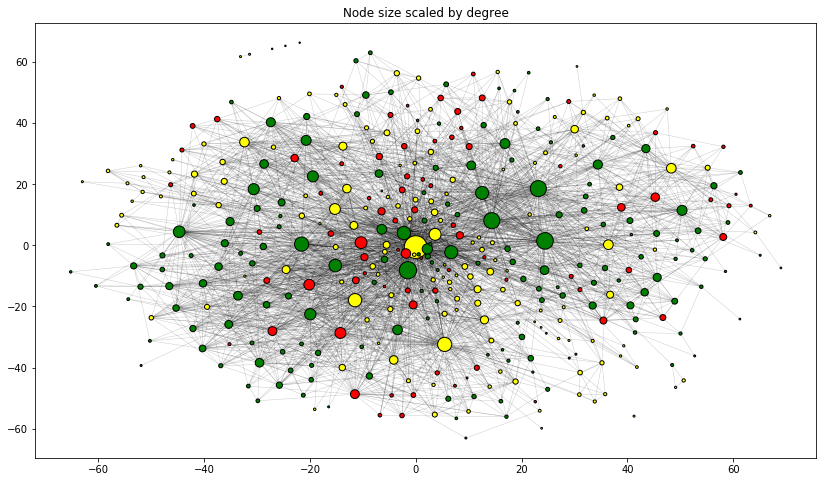

In [78]:
plt.figure(figsize=(14,8))
plt.title("Node size scaled by degree")

sizemap_degree = []
colormap = []
colors = ["red", "yellow", "green"]
for node in G_undir:
    sizemap_degree.append(G.degree(node, weight="weight") + 2)
    idx = 1
    if G.node[node]['goodness'] > 0:
        idx = 2
    elif G.node[node]['goodness'] < 0:
        idx = 0
    colormap.append(colors[idx])
nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)

plt.show()

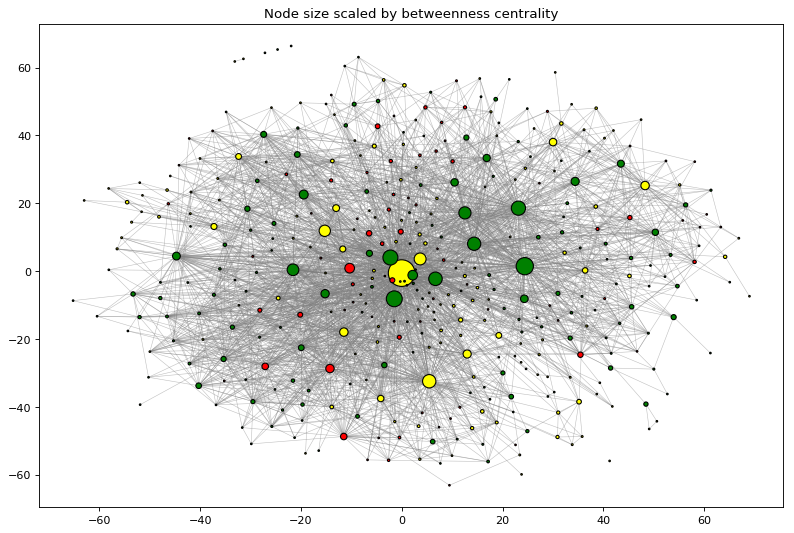

In [79]:
btw_cnt = nx.betweenness_centrality(G, weight="weight")

btw_cnt = list(map(lambda n: btw_cnt[n], nodelist))
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by betweenness centrality")
scale_node = 3000
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist,
                       node_color=colormap, edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, btw_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", alpha=0.5, width=0.5)

plt.show()

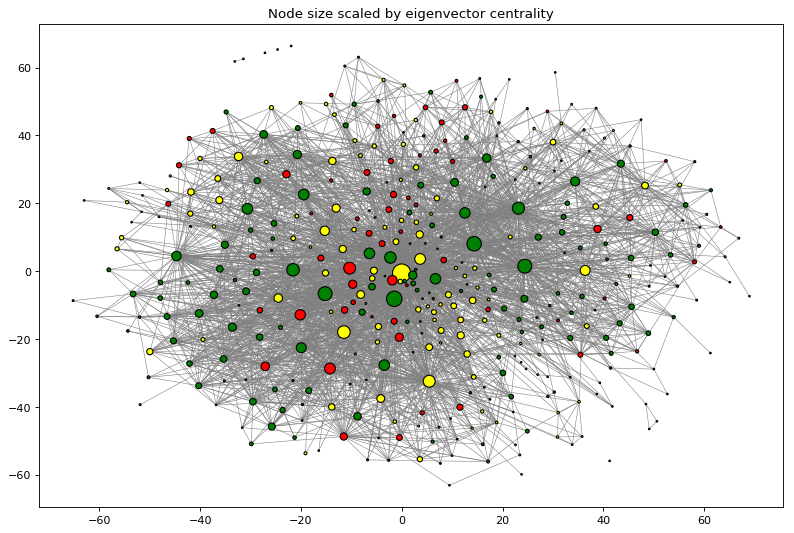

In [80]:
eig_cnt = nx.eigenvector_centrality(G, weight="weight")
eig_cnt = list(map(lambda n: eig_cnt[n], nodelist))

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by eigenvector centrality")
scale_node = 700
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap,
                       edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, eig_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="gray", width=0.5)

plt.show()

In [81]:
in_degrees = [G.in_degree(x) for x in G.nodes()]
out_degrees = [G.out_degree(x) for x in G.nodes()]
degrees = [G.degree(x) for x in G.nodes()]

degrees_names = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)
out_degrees_names = sorted(G.nodes, key=lambda x: G.out_degree(x), reverse=True)
in_degrees_names = sorted(G.nodes, key=lambda x: G.in_degree(x), reverse=True)
goodness_names = sorted (G.nodes, key=lambda x: G.node[x]['goodness'], reverse=True)
print(degrees_names[:5])

['Anakin Skywalker', 'Obi-Wan Kenobi', 'Leia Organa', 'Han Solo', 'Luke Skywalker']


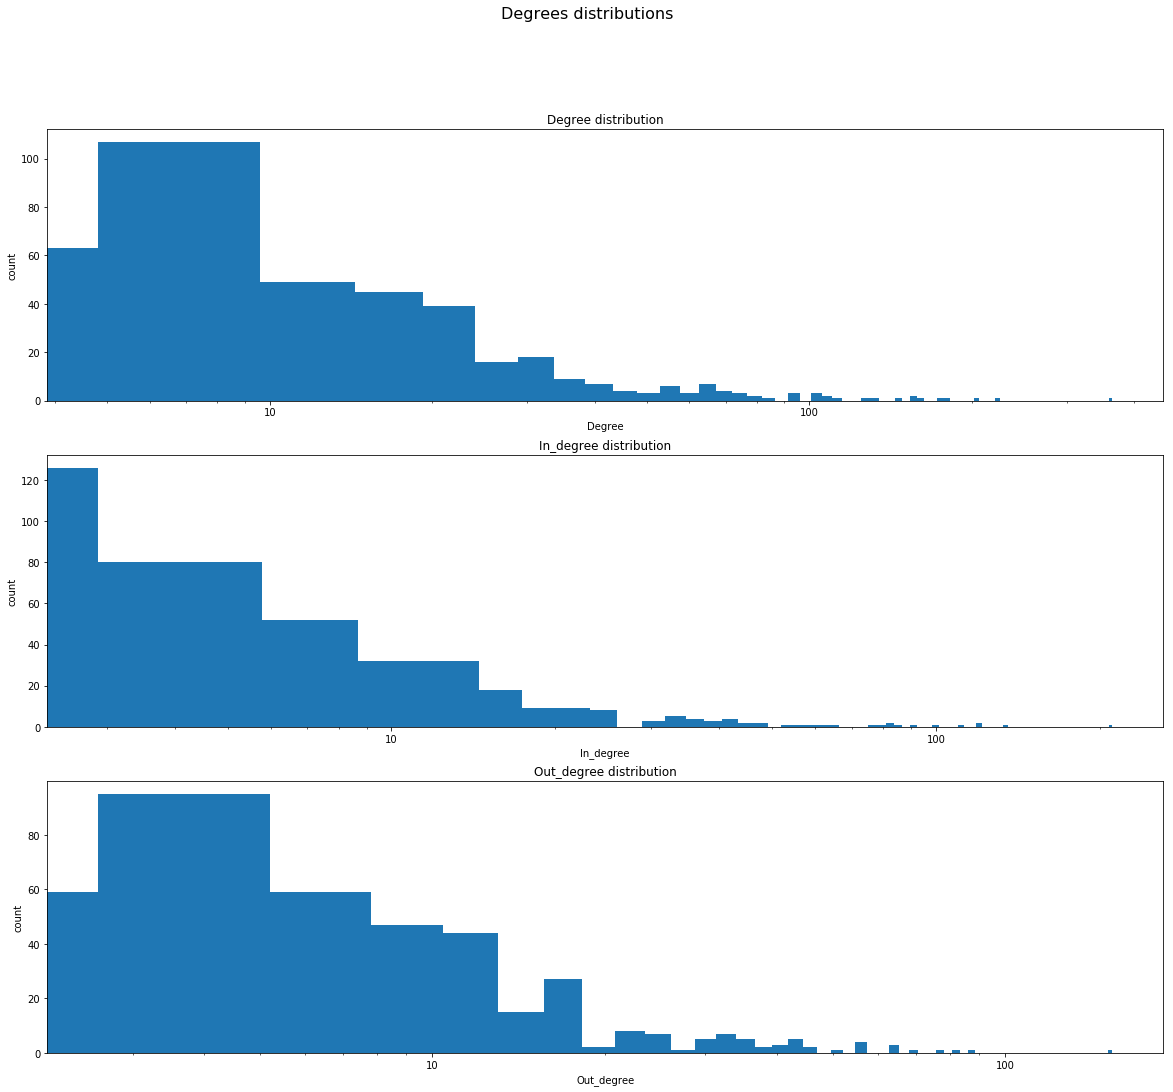

In [82]:
fig = plt.figure(figsize=(20,17))
fig.suptitle("Degrees distributions", fontsize=16)
ax = plt.subplot("311")
ax.set_title("Degree distribution")
ax.hist(degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("Degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())


ax = plt.subplot("312")
ax.set_title("In_degree distribution")
ax.hist(in_degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("In_degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax = plt.subplot("313")
ax.set_title("Out_degree distribution")
ax.hist(out_degrees, bins='auto')
ax.set_ylabel("count")
ax.set_xlabel("Out_degree")
ax.set_xscale('log')
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()

# Wordcloud over characters

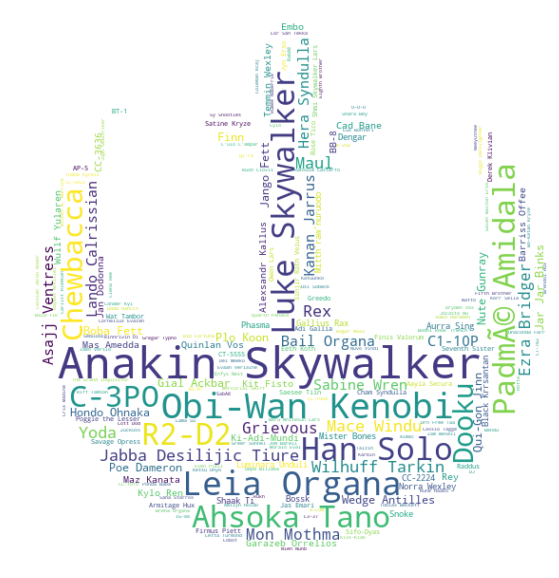

In [85]:
freqs = {}
for node in G:
    freqs[node] = G.degree(node) 
r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
wordcloud = WordCloud(background_color="white", max_words=2000, mask=r2_mask)

wordcloud.generate_from_frequencies(freqs)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()